# Double DQN

In this notebook, we will implement Deep Q-Learning Reinforcement learning algorithm for Lunar Lander Environment.

## Lunar Lander

This environment is a classic rocket trajectory optimization problem. The landing pad is always at coordinates (0,0). The state is an 8-dimensional vector: the coordinates of the lander in x & y, its linear velocities in x & y, its angle, its angular velocity, and two booleans that represent whether each leg is in contact with the ground or not.

There are four discrete actions available:<br>
- 0: do nothing<br>
- 1: fire left orientation engine<br>
- 2: fire main engine<br>
- 3: fire right orientation engine<br>

After every step a reward is granted. The total reward of an episode is the sum of the rewards for all the steps within that episode.

For each step, the reward:

- is increased/decreased the closer/further the lander is to the landing pad.

- is increased/decreased the slower/faster the lander is moving.

- is decreased the more the lander is tilted (angle not horizontal).

- is increased by 10 points for each leg that is in contact with the ground.

- is decreased by 0.03 points each frame a side engine is firing.

- is decreased by 0.3 points each frame the main engine is firing.

The episode receive an additional reward of -100 or +100 points for crashing or landing safely respectively.

An episode is considered a solution if it scores at least 200 points.


You can read more the LunarLander environment [here](https://gymnasium.farama.org/environments/box2d/lunar_lander/)

![LunarLander](https://gymnasium.farama.org/_images/lunar_lander.gif)

## Deep Q-Learning

The main idea behind Q-learning is that if we had a function
$Q^*: State \times Action \rightarrow \mathbb{R}$, that could tell
us what our return would be, if we were to take an action in a given
state, then we could easily construct a policy that maximizes our
rewards:

\begin{align}\pi^*(s) = \arg\!\max_a \ Q^*(s, a)\end{align}

But this is not scalable. Must compute $Q(s,a)$ for every state-action pair. If state is e.g. current game state pixels, computationally infeasible to compute for entire state space! But, since neural networks are universal function
approximators, we can simply create one and train it to resemble
$Q^*$.

For our training update rule, we'll use a fact that every $Q$
function for some policy obeys the Bellman equation:

\begin{align}Q^{\pi}(s, a) = r + \gamma Q^{\pi}(s', \pi(s'))\end{align}

The difference between the two sides of the equality is known as the
temporal difference error, $\delta$:

\begin{align}\delta = Q(s, a) - (r + \gamma \max_a Q(s', a))\end{align}

To minimise this error, we will use the `Huber
loss <https://en.wikipedia.org/wiki/Huber_loss>`__. The Huber loss acts
like the mean squared error when the error is small, but like the mean
absolute error when the error is large - this makes it more robust to
outliers when the estimates of $Q$ are very noisy. We calculate
this over a batch of transitions, $B$, sampled from the replay
memory:

\begin{align}\mathcal{L} = \frac{1}{|B|}\sum_{(s, a, s', r) \ \in \ B} \mathcal{L}(\delta)\end{align}

\begin{align}\text{where} \quad \mathcal{L}(\delta) = \begin{cases}
     \frac{1}{2}{\delta^2}  & \text{for } |\delta| \le 1, \\
     |\delta| - \frac{1}{2} & \text{otherwise.}
   \end{cases}\end{align}



### Double Deep Q-Learning

We will implement Double Deep Q-Learning here. Double Deep Q-Learning is used to reduce the maximaztion bias in Q-Learning. This entails separate action selection and action evaluation in the target value.

- Use the current network to select the max action for the next state
and then use the target network to get the target Q-value for that
action.




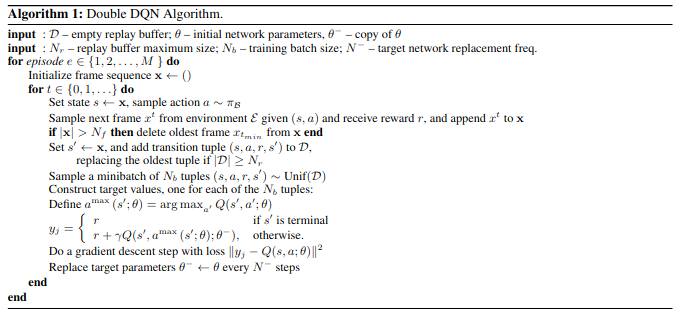

[Image Source](https://leejungi.github.io/posts/Dueling-DQN/)

In [123]:
!pip3 install -q swig
!pip3 install -q gym[box2d]

You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
zsh:1: no matches found: gym[box2d]


In [124]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
from collections import deque
import collections
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [125]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [126]:
# Create the environment
env = gym.make("LunarLander-v2")

### Experience Replay

Learning from batches of consecutive samples is problematic as the sample are correlated and it can create a bad feedback loop if one action is dominated in the samples.

We can address these problems using an experience replay memory. It maintains a record for all the transitions experienced. The agent is then trained by sampling random minibatches from the replay memory.

In [127]:

class MemoryBuffer:
    def __init__(self, max_size):

        # The size of the memory buffer, i.e. how many transitions can be kept
        self.memory_size = max_size
        # A counter for the number of transitions stored in the memory
        self.trans_counter = 0
        # A buffer containing the transitions using a FIFO principle
        self.buffer = collections.deque(maxlen=self.memory_size)

    def store_transition(self, state, action, reward, new_state, terminal):
        # Save a transition tuple into the memory buffer.
        transition = (state, action, reward, new_state, terminal)
        self.buffer.append(transition)

        # Update the counter, and reset if it the memory is full
        self.trans_counter = (self.trans_counter + 1) % self.memory_size

    def random_sample(self, batch_size):
        
        # Ensure that the sampling operation does not attempt to draw more transitions than are currently available in the memory buffer
        if len(self.buffer) < batch_size:
            batch_size = len(self.buffer)

        # Sample a batch of transitions
        transitions = random.sample(self.buffer, k=batch_size)
        states, actions, rewards, new_states, terminals = zip(*transitions)

        # Return all the elements of the transition
        return (
            torch.tensor(states, dtype=torch.float32, device=device),
            torch.tensor(actions, dtype=torch.long, device=device),
            torch.tensor(rewards, dtype=torch.float32, device=device),
            torch.tensor(new_states, dtype=torch.float32, device=device),
            torch.tensor(terminals, dtype=torch.float32, device=device)
        )

### Q-Network

In [128]:
class QNN(nn.Module):
    def __init__(self, state_size, action_size, seed):
        # Initialize a neural network model for Q-learning.
        super().__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size)
        
    def forward(self, state):
        # Forward pass of the neural network.
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

### Exploration vs Exploitation

Notice that Q-learning only learns about the states and actions it visits. What if an optimal state remains unvisited due to not being explored. The agent should sometimes pick suboptimal actions in order to visit new states and actions. <br>

A simple strategy is to use an $\epsilon$-greedy policy. According to this policy, the agent takes a random action with epsilon probability. The value of epsilon is high at the start of training and low towards the end. So, the agent explores more at the start and then exploit the learned policy more at the end.

### Hyperparameters

In [129]:
# Hyperparameters
gamma = 0.99  # discount factor
epsilon = 1.0  # exploration rate
batch_size=128 # batch size for training
epsilon_dec = 0.996  # decay rate of epsilon
epsilon_end = 0.01  # minimum value of epsilon
batch_size = 64  # batch size for training
lr = 0.001  # learning rate
max_buffer = 1000000  # maximum size of replay memory
num_episodes = 1000  # number of episodes for training
replace_q_target = 100  # frequency to update the target network


### Training

In [130]:

class Agent:
    def __init__(self, gamma, epsilon, batch_size, lr,
                 epsilon_dec, epsilon_end, max_buffer):
        # Initialize a reinforcement learning agent.
        self.memory = MemoryBuffer(max_buffer)
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_dec = epsilon_dec
        self.epsilon_min = epsilon_end
        self.batch_size = batch_size

    def save_transition(self, state, action, reward, new_state, done):
        # Funtion to just save transition into the agent's memory buffer.
        self.memory.store_transition(state, action, reward, new_state, done)

    def choose_action(self, state):
        # Choose an action based on the current state using the epsilon-greedy policy.
        if np.random.random() > self.epsilon:
            state = torch.tensor(state, dtype=torch.float32, device=device)
            with torch.no_grad():
                action_values = self.q_func(state.unsqueeze(0))
            return torch.argmax(action_values, dim=1).item()
        else:
            return np.random.choice(range(4))

    def reduce_epsilon(self):
        # Reduce the exploration rate epsilon.
        self.epsilon = max(self.epsilon * self.epsilon_dec, self.epsilon_min)

    def learn(self):
        # Learn from a batch of experiences in the memory buffer.
        raise NotImplementedError("Subclass must implement abstract method")

    def save_model(self, path):
        # Save the model parameters to a file.
        torch.save(self.q_func.state_dict(), path)

    def load_saved_model(self, path):
        # Load model parameters from a saved file.
        self.q_func = QNN(8, 4, 42).to(device)
        self.q_func.load_state_dict(torch.load(path))
        self.q_func.eval()

class DoubleQAgent(Agent):
    def __init__(self, gamma=0.99, epsilon=1.0, batch_size=128, lr=0.001,
                 epsilon_dec=0.996, epsilon_end=0.01,
                 mem_size=1000000, replace_q_target=100):
        # Initialize a double Q-learning agent.
        super().__init__(gamma, epsilon, batch_size, lr, epsilon_dec, epsilon_end, mem_size)
        self.replace_q_target = replace_q_target
        self.q_func = QNN(8, 4, 42).to(device)
        self.q_func_target = QNN(8, 4, 42).to(device)
        self.optimizer = optim.Adam(self.q_func.parameters(), lr=lr)

    def learn(self):
        # Update the Q-network based on experiences in the memory buffer.
        if len(self.memory.buffer) < self.batch_size:
            return
        
        states, actions, rewards, new_states, terminals = self.memory.random_sample(self.batch_size)
        
        q_next = self.q_func_target(new_states).detach().max(1)[0].unsqueeze(1)
        q_updated = rewards + self.gamma * q_next * (1 - terminals)
        q = self.q_func(states).gather(1, actions.unsqueeze(1))
        
        loss = F.mse_loss(q, q_updated)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        if self.memory.trans_counter % self.replace_q_target == 0:
            self.q_func_target.load_state_dict(self.q_func.state_dict())
        
        self.reduce_epsilon()

    def save_model(self, path):
        # Save the model parameters to a file.
        super().save_model(path)
        torch.save(self.q_func.state_dict(), path + '.q_func')
        torch.save(self.q_func_target.state_dict(), path + '.q_func_target')

    def load_saved_model(self, path):
        # Load model parameters from a saved file.
        super().load_saved_model(path)
        self.q_func_target = QNN(8, 4, 42).to(device)
        self.q_func_target.load_state_dict(torch.load(path + '.q_func_target'))
        self.q_func_target.eval()


In [131]:

LEARN_EVERY = 4
def train_agent(n_episodes=2000, load_latest_model=False):
    print("Training a DDQN agent on {} episodes. Pretrained model = {}".format(n_episodes,load_latest_model))
    env = gym.make("LunarLander-v2")
    agent = DoubleQAgent(gamma=0.99, epsilon=1.0, epsilon_dec=0.995, lr=0.001, mem_size=200000, batch_size=128, epsilon_end=0.01)
    if load_latest_model:
        agent.load_saved_model('ddqn_torch_model.h5')
        print('Loaded most recent: ddqn_torch_model.h5')
        
    scores = []
    eps_history = []
    start = time.time()
    for i in range(n_episodes):
        terminated = False
        truncated = False
        score = 0
        state = env.reset()[0]
        steps = 0
        while not (terminated or truncated):
            action = agent.choose_action(state)
            new_state, reward, terminated, truncated, info = env.step(action)
            agent.save_transition(state, action, reward, new_state, terminated)
            state = new_state
            if steps > 0 and steps % LEARN_EVERY == 0:
                agent.learn()
            steps += 1
            score += reward
            
        eps_history.append(agent.epsilon)
        scores.append(score)
        avg_score = np.mean(scores[max(0, i-100):(i+1)])

        if (i+1) % 10 == 0 and i > 0:
            # Report expected time to finish the training
            print('Episode {} in {:.2f} min. Expected total time for {} episodes: {:.0f} min. [{:.2f}/{:.2f}]'.format((i+1), 
                                                                                                                      (time.time() - start)/60, 
                                                                                                                      n_episodes, 
                                                                                                                      (((time.time() - start)/i)*n_episodes)/60, 
                                                                                                                      score, 
                   
                                                                                                                       avg_score))
            agent.save_model('ddqn_torch_model')

        if (i+1) % 100 == 0 and i > 0:
            # Save the model every N-th step just in case
            agent.save_model('ddqn_torch_model.h5')
            with open("ddqn_torch_dqn_scores_{}.json".format(int(time.time())), "w") as fp:
                json.dump(scores, fp)
            with open("ddqn_torch_eps_history_{}.json".format(int(time.time())), "w") as fp:
                json.dump(eps_history, fp)
                
    return agent


### Visualization

In [132]:
# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob
import base64, io, os

os.environ['SDL_VIDEODRIVER']='dummy'

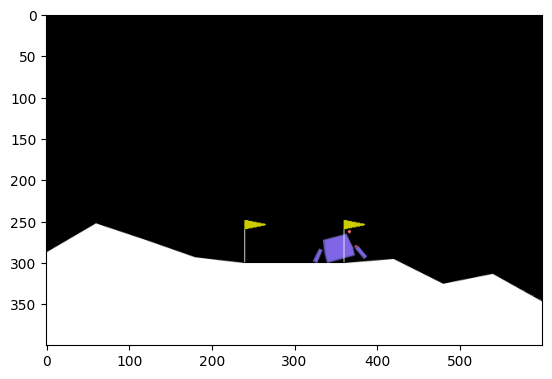

In [133]:
# Visualize the model
import gymnasium as gym
import os
import matplotlib.pyplot as plt
os.environ["SDL_VIDEODRIVER"] = "dummy"
from IPython.display import clear_output

# Set path to the model to visualize
model_to_animate = 'ddqn_torch_model'

def animate_model(name, atype='single'):
    env = gym.make("LunarLander-v2", render_mode="rgb_array")
    agent = DoubleQAgent(gamma=0.99, epsilon=0.0, lr=0.0005, mem_size=200000, batch_size=64, epsilon_end=0.01)
    agent.load_saved_model(name)
    state, info = env.reset(seed=12)
    for _ in range(5):
        terminated = False
        truncated = False
        while not (terminated or truncated):
            action = agent.choose_action(state)
            new_state, reward, terminated, truncated, info = env.step(action)
            state = new_state
            clear_output(wait=True)
            plt.imshow( env.render() )
            plt.show()
        state = env.reset()[0]
    env.close()

animate_model(model_to_animate, atype='double')





